In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from concurrent.futures import ThreadPoolExecutor
from geopy.geocoders import Photon
import folium
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dataframe_venda = pd.read_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_analise.parquet')

print("Quantidade de imóveis: ", dataframe_venda.shape[0])
print("Porcentagem de informações faltantes: ")
display(round(dataframe_venda.isna().sum()/dataframe_venda.shape[0] * 100, 2).astype(str) + " %")

Quantidade de imóveis:  3861
Porcentagem de informações faltantes: 


url                          0.0 %
endereco                     0.0 %
preco                        0.0 %
area                         0.0 %
quartos                      0.0 %
vagas_de_carro               0.0 %
valor_condominio             0.0 %
iptu                         0.0 %
mobiliado                    0.0 %
piscina                      0.0 %
condominio                   0.0 %
elevador                     0.0 %
jardim                       0.0 %
quadra_esportiva             0.0 %
academia                     0.0 %
finalidade                   0.0 %
tipo                         0.0 %
localizacao                  0.0 %
latitude                     0.0 %
longitude                    0.0 %
geometry                     0.0 %
nome                       11.34 %
distancia_metro            10.98 %
distancia_escola           10.98 %
distancia_unidade_saude    10.98 %
indic_rend                 11.34 %
indic_lixo                 11.34 %
indic_esgo                 11.34 %
indic_agua          

In [4]:
dataframe_final = dataframe_venda.dropna()

print("Quantidade de imóveis: ", dataframe_final.shape[0])

Quantidade de imóveis:  3423


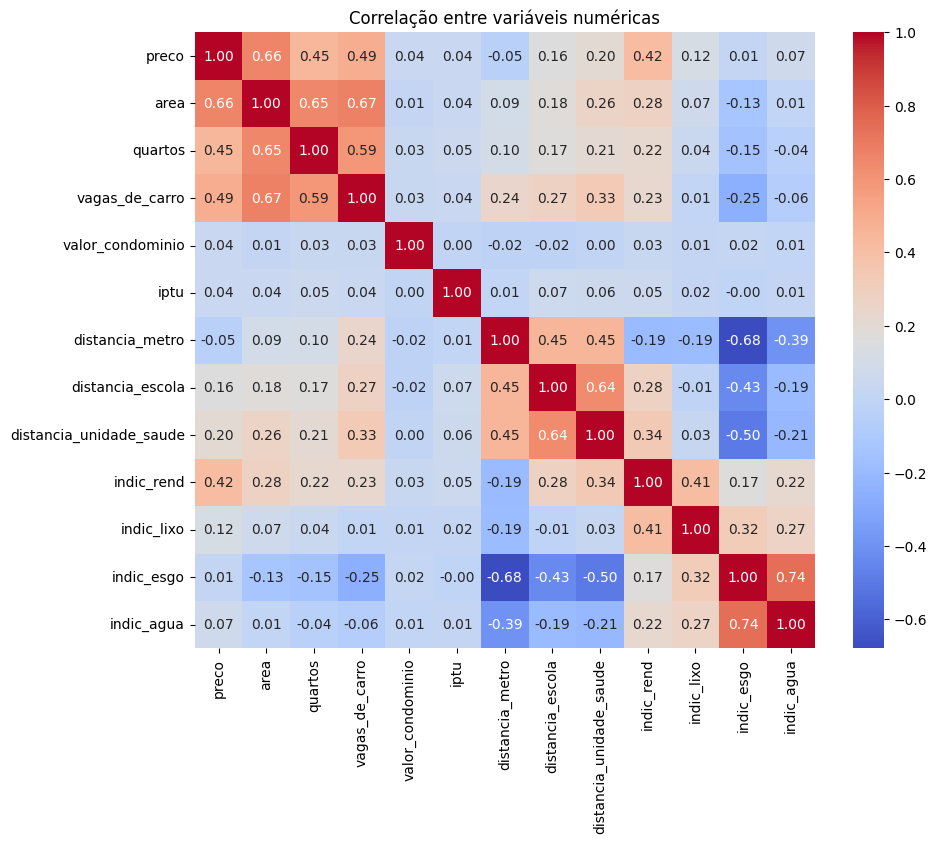

In [5]:
# Seleção de colunas numéricas
numeric_cols = dataframe_final.select_dtypes(include=['float64', 'int64'])

# Matriz de correlação
correlation_matrix = numeric_cols.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()

In [6]:
correlation_matrix

,preco,area,quartos,vagas_de_carro,valor_condominio,iptu,distancia_metro,distancia_escola,distancia_unidade_saude,indic_rend,indic_lixo,indic_esgo,indic_agua
preco,1.000000,0.660691,0.449038,0.490428,0.041463,0.040852,-0.048149,0.162491,0.203038,0.418915,0.119189,0.010241,0.073531
area,0.660691,1.000000,0.645875,0.674493,0.011689,0.040512,0.092055,0.175450,0.261877,0.283766,0.069100,-0.133229,0.007741
quartos,0.449038,0.645875,1.000000,0.590392,0.032928,0.052867,0.099406,0.167477,0.210989,0.219659,0.043452,-0.154148,-0.042905
vagas_de_carro,0.490428,0.674493,0.590392,1.000000,0.029850,0.039602,0.241003,0.272868,0.331700,0.228739,0.006861,-0.254153,-0.064717
valor_condominio,0.041463,0.011689,0.032928,0.029850,1.000000,0.002050,-0.017898,-0.016570,0.000203,0.033014,0.011701,0.020224,0.007720
iptu,0.040852,0.040512,0.052867,0.039602,0.002050,1.000000,0.009364,0.065488,0.055637,0.049302,0.015283,-0.004182,0.009746
distancia_metro,-0.048149,0.092055,0.099406,0.241003,-0.017898,0.009364,1.000000,0.454135,0.454180,-0.194427,-0.193223,-0.678925,-0.390597
distancia_escola,0.162491,0.175450,0.167477,0.272868,-0.016570,0.065488,0.454135,1.000000,0.637138,0.276352,-0.010738,-0.432601,-0.194633
distancia_unidade_saude,0.203038,0.261877,0.210989,0.331700,0.000203,0.055637,0.454180,0.637138,1.000000,0.341993,0.029197,-0.499294,-0.210465
indic_rend,0.418915,0.283766,0.219659,0.228739,0.033014,0.049302,-0.194427,0.276352,0.341993,1.000000,0.414094,0.167912,0.224958


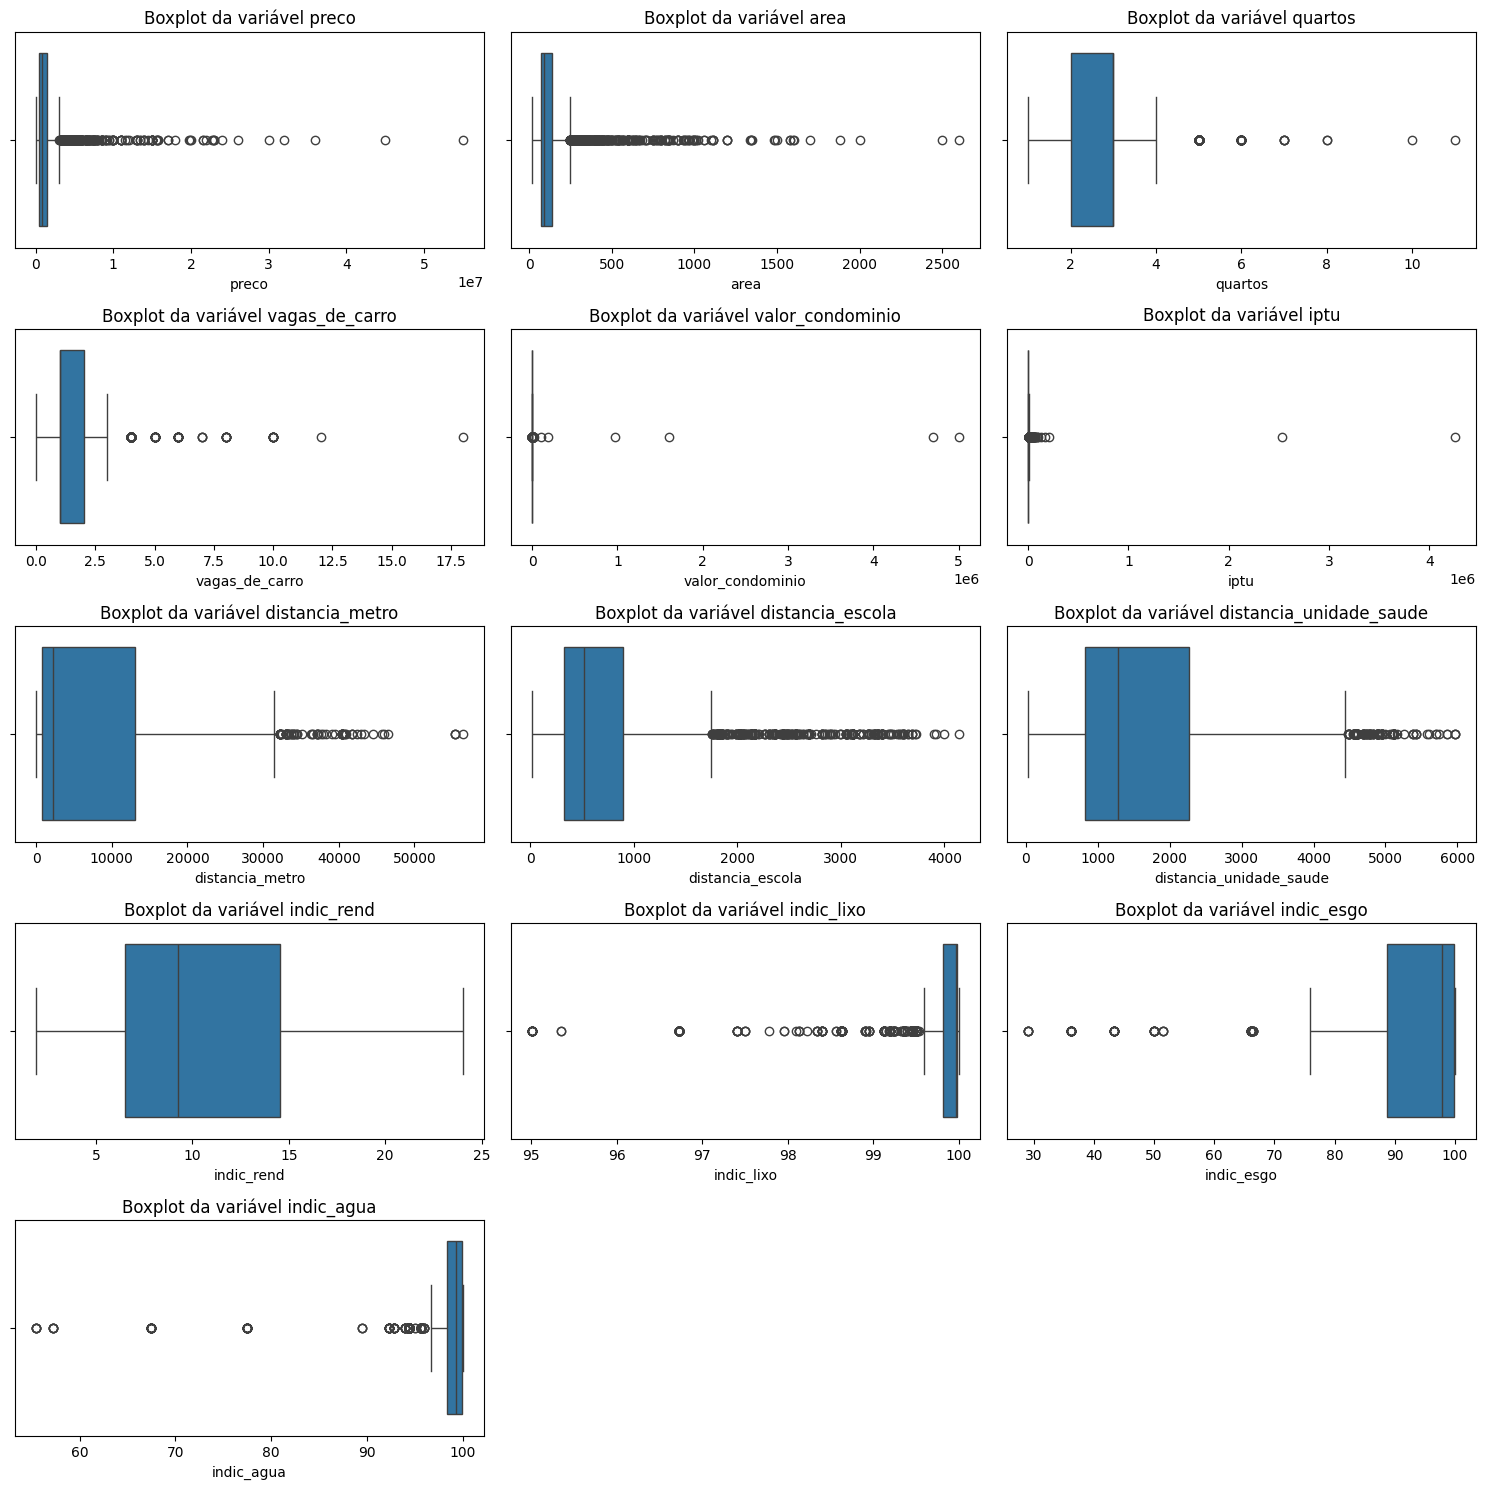

(3423, 29)


In [7]:
def plotar_boxplot(dataframe, colunas=['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio', 'distancia_metro', 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_agua'], tipo="boxplot"):

    # Número de colunas e linhas para subplots
    num_colunas = 3
    num_linhas = len(colunas) // num_colunas + (1 if len(colunas) % num_colunas != 0 else 0)

    # Criar os subplots
    plt.figure(figsize=(15, 3 * num_linhas))

    # Criar um boxplot para cada variável em cada subplot
    for i, coluna in enumerate(colunas):
        if tipo == "boxplot":
            plt.subplot(num_linhas, num_colunas, i + 1)
            sns.boxplot(x=dataframe[coluna])
            plt.title(f"Boxplot da variável {coluna}")
        if tipo == "histograma":
            plt.subplot(num_linhas, num_colunas, i + 1)
            sns.histplot(dataframe[coluna])
            plt.title(f"Histograma da variável {coluna}")
    
    # Ajustar o layout para não sobrepor os gráficos
    plt.tight_layout()
    plt.show()

colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio',
                   'iptu', 'distancia_metro', 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_esgo', 'indic_agua']
plotar_boxplot(dataframe_final, colunas_analise)

print(dataframe_final.shape)


(756, 29)


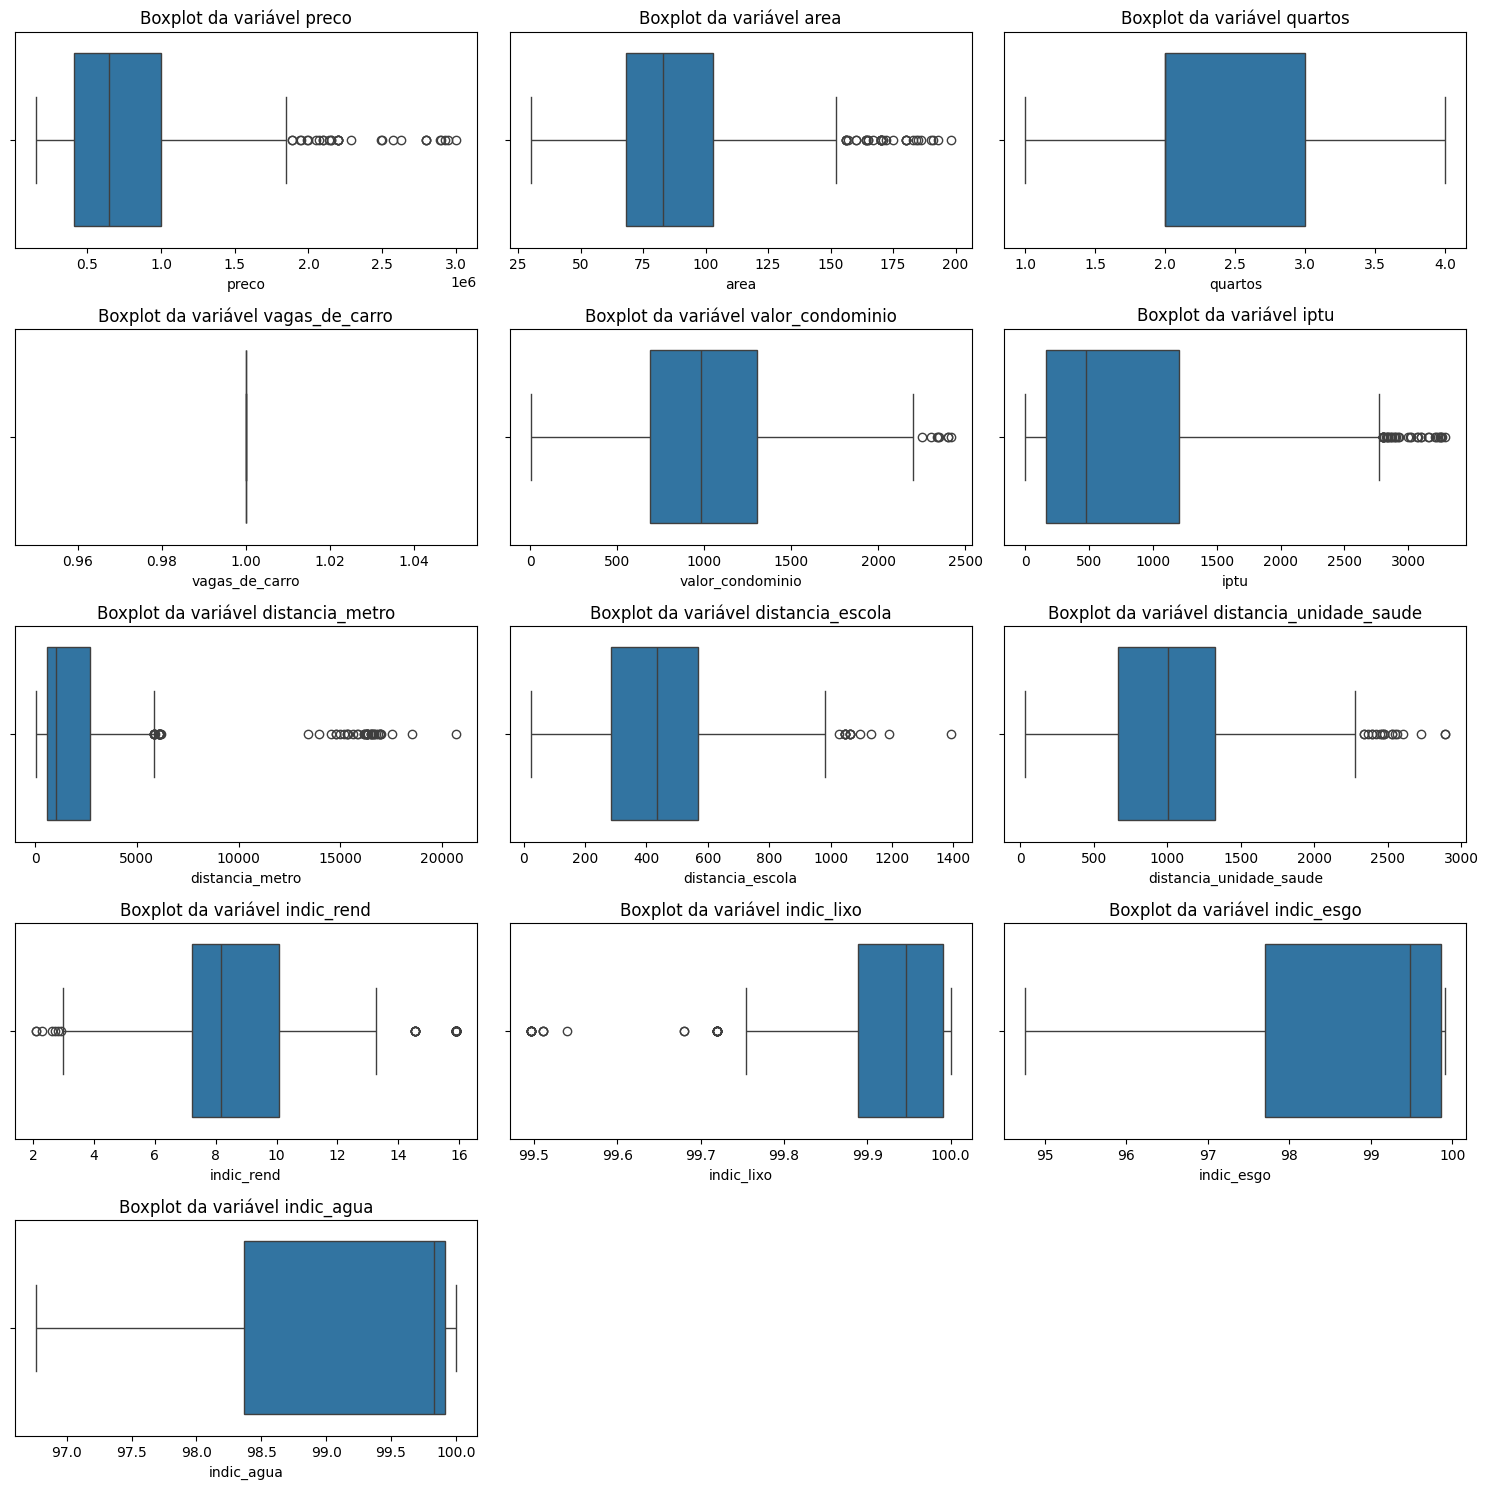

In [8]:
def identificar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return limite_inferior, limite_superior

# Remover outliers
for coluna in colunas_analise:
    limite_inferior, limite_superior = identificar_outliers(dataframe_final, coluna)
    dataframe_final = dataframe_final[
        (dataframe_final[coluna] >= limite_inferior) & (dataframe_final[coluna] <= limite_superior)
    ]
#dataframe_final = dataframe_final[dataframe_final["preco"] < 30000]

print(dataframe_final.shape)
plotar_boxplot(dataframe_final, colunas_analise)


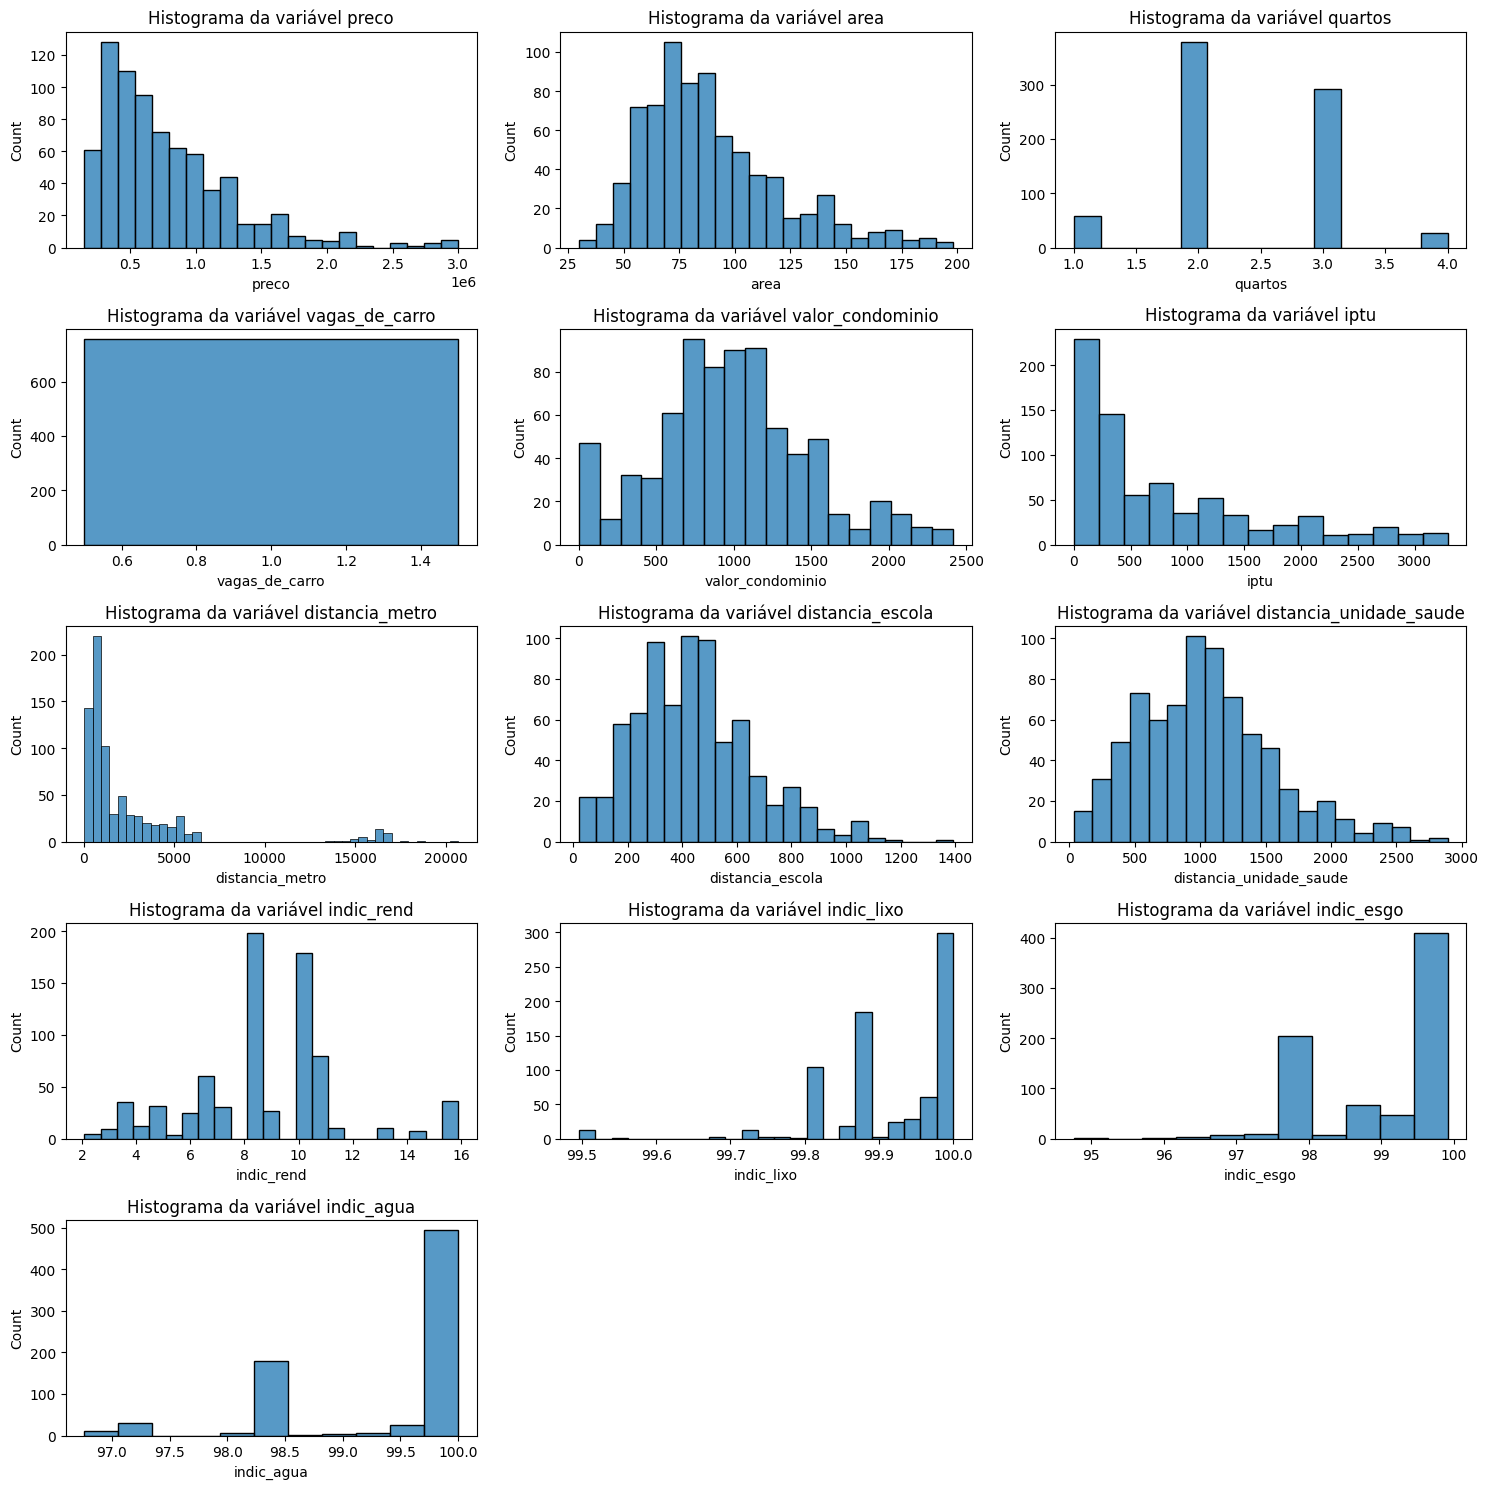

In [9]:
plotar_boxplot(dataframe_final, colunas_analise, tipo="histograma")

In [14]:
dataframe_final.to_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_predicao.parquet')